In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/ecg_ppg/'
dfs = []
for f in os.listdir(directory)[:50]:
    if f[-1]!='p':
        continue
    a = pickle.load(open(directory+f,'rb'))
    print(a.shape,end=',')
    dfs.append(a)
print()
data1 = pd.concat(dfs)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
data_all = deepcopy(data1)

data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
values = data_all[['ppg_rr','index']].values
values = [a[b] for a,b in values]
data_all['ppg_rr_best'] = values
data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))

In [ ]:
import pickle
pickle.dump(data_all,open('../data_users/merged_data.p','wb'),protocol=4)

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
data_all = pickle.load(open('../data_users/merged_data.p','rb'))

In [2]:
data_all.shape

(29536929, 18)

In [3]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
def get_data1(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>20:
        return [],[],[],[],[],[]
    ecg_rr[np.isnan(ecg_rr)] = np.nanmean(ecg_rr)
    m = np.mean(ecg_rr[ecg_rr>0])
    s = np.mean(ecg_rr[ecg_rr>0])
    if len(ecg_rr)<60:
        return [],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<30:
            continue
        index = np.isnan(ppg_rr)
        ppg_qual[index] = -1
        index = np.isnan(ppg_qual)
        ppg_qual[index] = -1
        tmp = a[:,np.array([-2,-3,-4,-5,-6,-7,-8,-9,1])].reshape(60,9)
        for k in range(4):
            tmp[np.isnan(tmp[:,k]),k] = np.nanmean(tmp[:,k])
            tmp[tmp[:,k]==0,k] = np.mean(tmp[tmp[:,k]>0,k])
        tmp[np.isnan(tmp)] = 0
        y.append(tmp[:,0].reshape(1,60,1))
        X.append(tmp.reshape(1,60,9))
        means.append(m)
        stds.append(s)
        ecg.append(ecg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
    return X,y,ecg,means,stds,quals

unique_users = data_all['user'].unique()

def get_data(name,df):
    df = df[['time','activity','red_qual','ir_qual','green_qual','likelihood_best',
             'red_rr','ir_rr','green_rr','ppg_rr_best','ecg_rr']].values
    return df.reshape(-1,60,11)
def get_all_data(data_user):
    data_user.set_index('timestamp',inplace=True)
    convert_dict = {'ecg_rr': float}
    data_user = data_user.astype(convert_dict) 
    data_resampled = data_user.resample('1S').mean()
    if 'ecg_rr' not in np.array(data_resampled.columns.values):
        return []
    df_col = [get_data(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60]
    df_user = np.concatenate(df_col)
    df_col = [get_data1(a) for a in df_user if len(a[~np.isnan(a[:,-1]),-1])>20]
    return df_col
# for user in unique_users:
#     data_user = data_all[data_all.user.isin([user])]
all_X = Parallel(n_jobs=20,verbose=3)(delayed(get_all_data)(data_all[data_all.user.isin([user])]) for user in unique_users)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  28 out of  50 | elapsed:  1.8min remaining:  1.4min
[Parallel(n_jobs=20)]: Done  45 out of  50 | elapsed:  2.8min remaining:   18.7s
[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:  3.2min finished


In [10]:
X,y,ecg,means,stds,quals = [],[],[],[],[],[]
for i,b in enumerate(all_X):
    if len(b)==0:
        continue
    for a in b:
        X.extend(a[0])
        y.extend(a[1])
        ecg.extend(a[2])
        means.extend(a[3])
        stds.extend(a[4])
        quals.extend(a[5])

In [11]:
import pickle
pickle.dump([X,y,ecg,means,stds,quals],open('../data_users/processed_data.p','wb'),protocol=4)

In [12]:
import pandas as pd
import pickle
import os
import numpy as np
X,y,ecg,means,stds,quals = pickle.load(open('../data_users/processed_data.p','rb'))

In [13]:
X,y,ecg,means,stds,quals = np.concatenate(X),np.concatenate(y).reshape(-1,60),np.concatenate(ecg).reshape(-1,60),\
np.array(means).reshape(-1,1),np.array(stds).reshape(-1,1),np.concatenate(quals)

In [17]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tfp
X_train, X_test, y_train, y_test,ecg_train, \
ecg_test,means_train,means_test,stds_train,stds_test, \
quals_train,quals_test= train_test_split(
    X[:,:,np.array([1,2,3,5,6,7])], y,ecg,means,stds,quals, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val,means_train,means_val,stds_train,stds_val = train_test_split(
    X_train, y_train,means_train,stds_train, test_size=0.2, random_state=42)
print(X_train.shape,y_test.shape,y_val.shape,means_val.shape,stds_val.shape)

(32330, 60, 6) (19905, 60) (8083, 60) (8083, 1) (8083, 1)


In [18]:
def output_of_lambda(input_shape):
    return (input_shape[0], 1)

def mean(x):
    return K.mean(x,axis=1,keepdims=True)

def output_of_lambda1(input_shape):
    return (input_shape[0], 1)

def mean1(x):
    return K.mean(x,axis=1,keepdims=True)

timesteps = 60
input_dim = 6
latent_dim = 20
output_dim = 1
n = 1
inputs = Input(shape=(timesteps, input_dim))
# inputs2 = Reshape((1,1))(inputs1)
encoded = Bidirectional(GRU(60,return_sequences=True,activation='linear',go_backwards=True))(inputs)
# encoded = LSTM(output_dim,return_sequences=True,activation='sigmoid')(encoded)
att = Dense(1,activation='relu')(encoded)

att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = RepeatVector(120)(att)
att = Permute((2,1))(att)
mer = multiply([att, encoded])

# encoded = TimeDistributed(Dense(,activation='relu'))(mer)
encoded = Flatten()(mer)
encoded = Dense(30,activation='relu',name='sequence1')(encoded)
encoded = Dense(60,activation='relu',name='sequence')(encoded)
# encoded = Reshape((60),name='sequence')(encoded)
# encoded_std = K.std(encoded,axis=1)
decoded = Lambda(mean, output_shape=output_of_lambda,name='mean')(encoded)
decoded1 = Lambda(mean1, output_shape=output_of_lambda1,name='std')(encoded)
# decoded = LSTM(output_dim*60, return_sequences=True)(decoded)
# decoded = LSTM(output_dim*3, return_sequences=True)(decoded)
# decoded = LSTM(output_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded,decoded,decoded1])
# encoder = Model(inputs, encoded)
losses = {
    "std":"logcosh",
    "mean": "logcosh",
    "sequence": "logcosh"
}
lossWeights = {"mean": 0, "sequence": 10,"std":0}
# initialize the optimizer and compile the model

sequence_autoencoder.compile(optimizer='adam',loss=losses, loss_weights=lossWeights)

sequence_autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 60, 6)        0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 60, 120)      24120       input_3[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 60, 1)        121         bidirectional_3[0][0]            
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 60)           0           dense_3[0][0]                    
____________________________________________________________________________________________

In [19]:
filepath = '../models/base_LSTM.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, [y_train,means_train,stds_train],
                epochs=300,
                batch_size=500,
                shuffle=True,
                validation_data=(X_val,[y_val,means_val,stds_val]),callbacks=callbacks_list)

Train on 32330 samples, validate on 8083 samples
Epoch 1/300
32330/32330 [==============================] - 8s 236us/step - loss: 4809.6112 - sequence_loss: 479.6400 - mean_loss: 392.4611 - std_loss: 392.4611 - val_loss: 2267.3897 - val_sequence_loss: 226.8455 - val_mean_loss: 117.2825 - val_std_loss: 117.2825

Epoch 00001: val_loss improved from inf to 2267.38967, saving model to ../models/base_LSTM.hdf5
Epoch 2/300
32330/32330 [==============================] - 7s 214us/step - loss: 2186.5969 - sequence_loss: 218.6516 - mean_loss: 116.2222 - std_loss: 116.2222 - val_loss: 2162.1162 - val_sequence_loss: 216.1712 - val_mean_loss: 114.0627 - val_std_loss: 114.0627

Epoch 00002: val_loss improved from 2267.38967 to 2162.11618, saving model to ../models/base_LSTM.hdf5
Epoch 3/300
32330/32330 [==============================] - 7s 209us/step - loss: 2148.4420 - sequence_loss: 214.8686 - mean_loss: 112.3638 - std_loss: 112.3638 - val_loss: 2141.3825 - val_sequence_loss: 214.2519 - val_mean_l

32330/32330 [==============================] - 8s 242us/step - loss: 1853.9290 - sequence_loss: 185.4025 - mean_loss: 90.1487 - std_loss: 90.1487 - val_loss: 1855.2472 - val_sequence_loss: 185.4550 - val_mean_loss: 88.4867 - val_std_loss: 88.4867

Epoch 00024: val_loss improved from 1859.85747 to 1855.24720, saving model to ../models/base_LSTM.hdf5
Epoch 25/300
32330/32330 [==============================] - 8s 244us/step - loss: 1852.2907 - sequence_loss: 185.2620 - mean_loss: 90.1493 - std_loss: 90.1493 - val_loss: 1850.4478 - val_sequence_loss: 184.9683 - val_mean_loss: 89.0549 - val_std_loss: 89.0549

Epoch 00025: val_loss improved from 1855.24720 to 1850.44781, saving model to ../models/base_LSTM.hdf5
Epoch 26/300
32330/32330 [==============================] - 9s 288us/step - loss: 1846.8842 - sequence_loss: 184.7020 - mean_loss: 89.7068 - std_loss: 89.7068 - val_loss: 1850.0687 - val_sequence_loss: 184.9662 - val_mean_loss: 90.1085 - val_std_loss: 90.1085

Epoch 00026: val_loss im


Epoch 00047: val_loss improved from 1553.82421 to 1518.94728, saving model to ../models/base_LSTM.hdf5
Epoch 48/300
32330/32330 [==============================] - 10s 296us/step - loss: 1532.9428 - sequence_loss: 153.3059 - mean_loss: 86.5836 - std_loss: 86.5836 - val_loss: 1521.1725 - val_sequence_loss: 152.1315 - val_mean_loss: 85.3281 - val_std_loss: 85.3281

Epoch 00048: val_loss did not improve from 1518.94728
Epoch 49/300
32330/32330 [==============================] - 10s 297us/step - loss: 1517.1539 - sequence_loss: 151.6990 - mean_loss: 86.3368 - std_loss: 86.3368 - val_loss: 1506.0903 - val_sequence_loss: 150.6341 - val_mean_loss: 85.4115 - val_std_loss: 85.4115

Epoch 00049: val_loss improved from 1518.94728 to 1506.09032, saving model to ../models/base_LSTM.hdf5
Epoch 50/300
32330/32330 [==============================] - 10s 296us/step - loss: 1515.3849 - sequence_loss: 151.5282 - mean_loss: 86.1219 - std_loss: 86.1219 - val_loss: 1565.2743 - val_sequence_loss: 156.5817 - v

32330/32330 [==============================] - 7s 212us/step - loss: 1429.2255 - sequence_loss: 142.9092 - mean_loss: 85.7348 - std_loss: 85.7348 - val_loss: 1419.2755 - val_sequence_loss: 141.9833 - val_mean_loss: 85.8132 - val_std_loss: 85.8132

Epoch 00072: val_loss improved from 1437.43823 to 1419.27550, saving model to ../models/base_LSTM.hdf5
Epoch 73/300
32330/32330 [==============================] - 7s 212us/step - loss: 1413.2073 - sequence_loss: 141.3172 - mean_loss: 85.8419 - std_loss: 85.8419 - val_loss: 1407.6050 - val_sequence_loss: 140.8415 - val_mean_loss: 88.7885 - val_std_loss: 88.7885

Epoch 00073: val_loss improved from 1419.27550 to 1407.60500, saving model to ../models/base_LSTM.hdf5
Epoch 74/300
32330/32330 [==============================] - 9s 273us/step - loss: 1409.0647 - sequence_loss: 140.8920 - mean_loss: 87.4291 - std_loss: 87.4291 - val_loss: 1412.3467 - val_sequence_loss: 141.2992 - val_mean_loss: 84.8015 - val_std_loss: 84.8015

Epoch 00074: val_loss di

32330/32330 [==============================] - 8s 244us/step - loss: 1280.6977 - sequence_loss: 128.0713 - mean_loss: 87.7037 - std_loss: 87.7037 - val_loss: 1282.3812 - val_sequence_loss: 128.3757 - val_mean_loss: 87.3068 - val_std_loss: 87.3068

Epoch 00095: val_loss improved from 1282.47508 to 1282.38122, saving model to ../models/base_LSTM.hdf5
Epoch 96/300
32330/32330 [==============================] - 8s 243us/step - loss: 1278.2132 - sequence_loss: 127.8099 - mean_loss: 87.7449 - std_loss: 87.7449 - val_loss: 1282.7540 - val_sequence_loss: 128.3906 - val_mean_loss: 84.6780 - val_std_loss: 84.6780

Epoch 00096: val_loss did not improve from 1282.38122
Epoch 97/300
32330/32330 [==============================] - 8s 243us/step - loss: 1277.1567 - sequence_loss: 127.7259 - mean_loss: 87.7962 - std_loss: 87.7962 - val_loss: 1278.9501 - val_sequence_loss: 128.0255 - val_mean_loss: 86.7006 - val_std_loss: 86.7006

Epoch 00097: val_loss improved from 1282.38122 to 1278.95007, saving mode

32330/32330 [==============================] - 10s 304us/step - loss: 1260.4775 - sequence_loss: 126.0129 - mean_loss: 87.6535 - std_loss: 87.6535 - val_loss: 1267.2592 - val_sequence_loss: 126.8502 - val_mean_loss: 87.9588 - val_std_loss: 87.9588

Epoch 00119: val_loss did not improve from 1264.69465
Epoch 120/300
32330/32330 [==============================] - 10s 305us/step - loss: 1261.6970 - sequence_loss: 126.1623 - mean_loss: 88.0524 - std_loss: 88.0524 - val_loss: 1267.3426 - val_sequence_loss: 126.8484 - val_mean_loss: 84.7980 - val_std_loss: 84.7980

Epoch 00120: val_loss did not improve from 1264.69465
Epoch 121/300
32330/32330 [==============================] - 10s 302us/step - loss: 1260.6889 - sequence_loss: 126.0742 - mean_loss: 87.8002 - std_loss: 87.8002 - val_loss: 1263.8886 - val_sequence_loss: 126.5103 - val_mean_loss: 88.3490 - val_std_loss: 88.3490

Epoch 00121: val_loss improved from 1264.69465 to 1263.88864, saving model to ../models/base_LSTM.hdf5
Epoch 122/300


32330/32330 [==============================] - 10s 303us/step - loss: 1244.5758 - sequence_loss: 124.4446 - mean_loss: 87.1438 - std_loss: 87.1438 - val_loss: 1251.5611 - val_sequence_loss: 125.2778 - val_mean_loss: 85.6017 - val_std_loss: 85.6017

Epoch 00143: val_loss did not improve from 1248.60124
Epoch 144/300
32330/32330 [==============================] - 10s 300us/step - loss: 1244.4811 - sequence_loss: 124.4526 - mean_loss: 87.0131 - std_loss: 87.0131 - val_loss: 1251.1370 - val_sequence_loss: 125.2183 - val_mean_loss: 85.7020 - val_std_loss: 85.7020

Epoch 00144: val_loss did not improve from 1248.60124
Epoch 145/300
32330/32330 [==============================] - 8s 244us/step - loss: 1243.3219 - sequence_loss: 124.3449 - mean_loss: 87.1606 - std_loss: 87.1606 - val_loss: 1248.1954 - val_sequence_loss: 124.9269 - val_mean_loss: 87.0370 - val_std_loss: 87.0370

Epoch 00145: val_loss improved from 1248.60124 to 1248.19536, saving model to ../models/base_LSTM.hdf5
Epoch 146/300
3

32330/32330 [==============================] - 9s 273us/step - loss: 1246.0168 - sequence_loss: 124.6067 - mean_loss: 86.7832 - std_loss: 86.7832 - val_loss: 1250.3410 - val_sequence_loss: 125.1151 - val_mean_loss: 85.9216 - val_std_loss: 85.9216

Epoch 00168: val_loss did not improve from 1239.89448
Epoch 169/300
32330/32330 [==============================] - 9s 275us/step - loss: 1246.2354 - sequence_loss: 124.6233 - mean_loss: 86.9462 - std_loss: 86.9462 - val_loss: 1250.6172 - val_sequence_loss: 125.1691 - val_mean_loss: 85.9226 - val_std_loss: 85.9226

Epoch 00169: val_loss did not improve from 1239.89448
Epoch 170/300
32330/32330 [==============================] - 7s 227us/step - loss: 1244.8361 - sequence_loss: 124.4632 - mean_loss: 87.1241 - std_loss: 87.1241 - val_loss: 1249.1343 - val_sequence_loss: 125.0074 - val_mean_loss: 86.0906 - val_std_loss: 86.0906

Epoch 00170: val_loss did not improve from 1239.89448
Epoch 171/300
32330/32330 [==============================] - 7s 21

32330/32330 [==============================] - 7s 211us/step - loss: 1224.9875 - sequence_loss: 122.4904 - mean_loss: 87.2629 - std_loss: 87.2629 - val_loss: 1230.5397 - val_sequence_loss: 123.1587 - val_mean_loss: 85.7544 - val_std_loss: 85.7544

Epoch 00193: val_loss did not improve from 1230.32726
Epoch 194/300
32330/32330 [==============================] - 8s 242us/step - loss: 1228.3430 - sequence_loss: 122.8289 - mean_loss: 86.8240 - std_loss: 86.8240 - val_loss: 1230.8809 - val_sequence_loss: 123.1887 - val_mean_loss: 87.0160 - val_std_loss: 87.0160

Epoch 00194: val_loss did not improve from 1230.32726
Epoch 195/300
32330/32330 [==============================] - 9s 276us/step - loss: 1224.9002 - sequence_loss: 122.5041 - mean_loss: 87.2546 - std_loss: 87.2546 - val_loss: 1230.9363 - val_sequence_loss: 123.2095 - val_mean_loss: 90.6060 - val_std_loss: 90.6060

Epoch 00195: val_loss did not improve from 1230.32726
Epoch 196/300
32330/32330 [==============================] - 9s 27

32330/32330 [==============================] - 8s 244us/step - loss: 1220.2423 - sequence_loss: 121.9837 - mean_loss: 87.2883 - std_loss: 87.2883 - val_loss: 1225.5493 - val_sequence_loss: 122.6839 - val_mean_loss: 88.0538 - val_std_loss: 88.0538

Epoch 00218: val_loss did not improve from 1223.48750
Epoch 219/300
32330/32330 [==============================] - 8s 243us/step - loss: 1218.9699 - sequence_loss: 121.8891 - mean_loss: 87.3915 - std_loss: 87.3915 - val_loss: 1226.5138 - val_sequence_loss: 122.7647 - val_mean_loss: 87.4977 - val_std_loss: 87.4977

Epoch 00219: val_loss did not improve from 1223.48750
Epoch 220/300
32330/32330 [==============================] - 8s 244us/step - loss: 1218.3036 - sequence_loss: 121.8304 - mean_loss: 87.5448 - std_loss: 87.5448 - val_loss: 1224.3279 - val_sequence_loss: 122.5343 - val_mean_loss: 85.9712 - val_std_loss: 85.9712

Epoch 00220: val_loss did not improve from 1223.48750
Epoch 221/300
32330/32330 [==============================] - 8s 24

32330/32330 [==============================] - 7s 209us/step - loss: 1210.4595 - sequence_loss: 121.0586 - mean_loss: 87.1651 - std_loss: 87.1651 - val_loss: 1217.6920 - val_sequence_loss: 121.8804 - val_mean_loss: 86.3432 - val_std_loss: 86.3432

Epoch 00242: val_loss did not improve from 1216.67950
Epoch 243/300
32330/32330 [==============================] - 7s 217us/step - loss: 1209.3881 - sequence_loss: 120.9073 - mean_loss: 87.0329 - std_loss: 87.0329 - val_loss: 1218.7331 - val_sequence_loss: 121.9911 - val_mean_loss: 86.5492 - val_std_loss: 86.5492

Epoch 00243: val_loss did not improve from 1216.67950
Epoch 244/300
32330/32330 [==============================] - 10s 303us/step - loss: 1211.6806 - sequence_loss: 121.1553 - mean_loss: 87.5123 - std_loss: 87.5123 - val_loss: 1218.3733 - val_sequence_loss: 121.9640 - val_mean_loss: 87.2350 - val_std_loss: 87.2350

Epoch 00244: val_loss did not improve from 1216.67950
Epoch 245/300
32330/32330 [==============================] - 10s 


Epoch 00266: val_loss improved from 1209.34085 to 1208.94363, saving model to ../models/base_LSTM.hdf5
Epoch 267/300
32330/32330 [==============================] - 7s 210us/step - loss: 1203.5636 - sequence_loss: 120.3607 - mean_loss: 87.4807 - std_loss: 87.4807 - val_loss: 1210.8184 - val_sequence_loss: 121.1680 - val_mean_loss: 85.7088 - val_std_loss: 85.7088

Epoch 00267: val_loss did not improve from 1208.94363
Epoch 268/300
32330/32330 [==============================] - 7s 210us/step - loss: 1202.2695 - sequence_loss: 120.2211 - mean_loss: 87.0068 - std_loss: 87.0068 - val_loss: 1208.1300 - val_sequence_loss: 120.9311 - val_mean_loss: 89.3979 - val_std_loss: 89.3979

Epoch 00268: val_loss improved from 1208.94363 to 1208.13000, saving model to ../models/base_LSTM.hdf5
Epoch 269/300
32330/32330 [==============================] - 7s 206us/step - loss: 1203.5690 - sequence_loss: 120.3533 - mean_loss: 87.4514 - std_loss: 87.4514 - val_loss: 1209.4850 - val_sequence_loss: 121.0622 - v

32330/32330 [==============================] - 7s 210us/step - loss: 1152.5322 - sequence_loss: 115.2506 - mean_loss: 87.8795 - std_loss: 87.8795 - val_loss: 1167.2087 - val_sequence_loss: 116.8456 - val_mean_loss: 87.8431 - val_std_loss: 87.8431

Epoch 00291: val_loss did not improve from 1139.62240
Epoch 292/300
32330/32330 [==============================] - 7s 209us/step - loss: 1151.9906 - sequence_loss: 115.1776 - mean_loss: 88.2560 - std_loss: 88.2560 - val_loss: 1150.3484 - val_sequence_loss: 115.1654 - val_mean_loss: 89.3685 - val_std_loss: 89.3685

Epoch 00292: val_loss did not improve from 1139.62240
Epoch 293/300
32330/32330 [==============================] - 7s 209us/step - loss: 1142.5327 - sequence_loss: 114.2534 - mean_loss: 88.1193 - std_loss: 88.1193 - val_loss: 1144.6928 - val_sequence_loss: 114.5933 - val_mean_loss: 88.2263 - val_std_loss: 88.2263

Epoch 00293: val_loss did not improve from 1139.62240
Epoch 294/300
32330/32330 [==============================] - 7s 21

In [20]:
from keras.models import load_model
import tensorflow_probability as tfp
sequence_autoencoder = load_model(filepath)

In [21]:
y_pred1 = sequence_autoencoder.predict(X_test)
y_pred = y_pred1[0]
mean_pred = y_pred1[1]
stds_pred = y_pred1[2]

In [22]:
y_pred1[0].shape,y_pred1[1].shape,y_pred1[2].shape

((19905, 60), (19905, 1), (19905, 1))

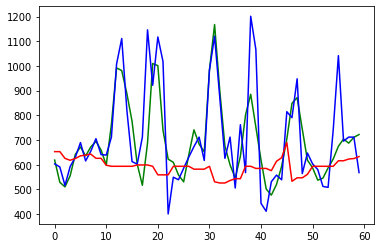

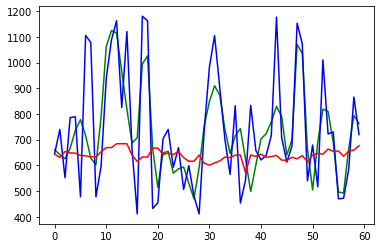

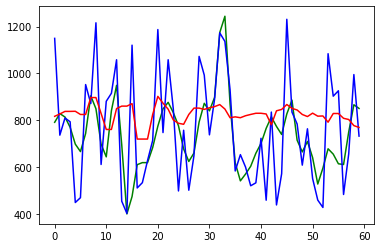

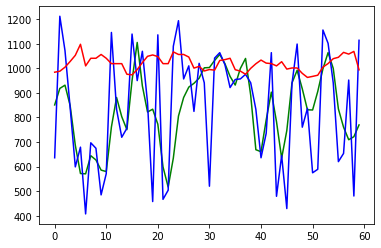

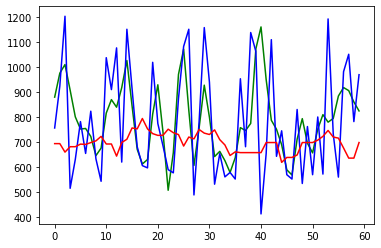

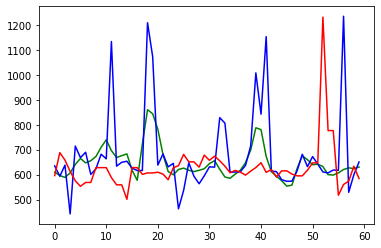

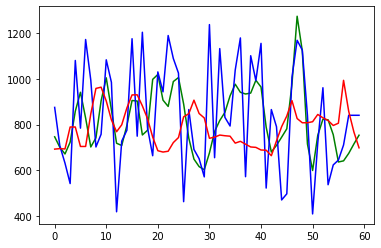

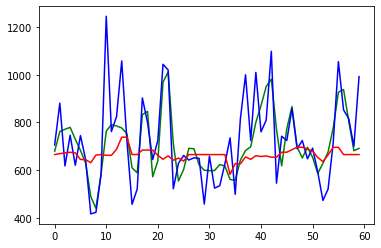

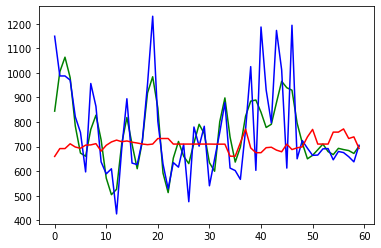

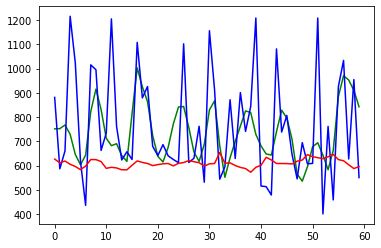

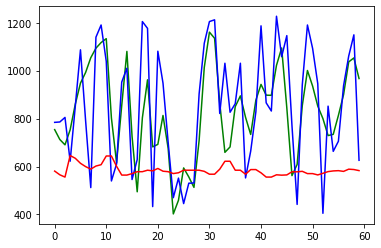

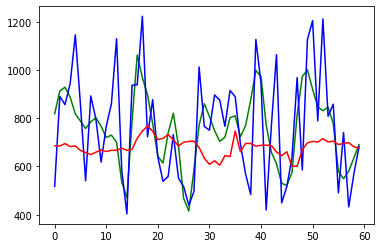

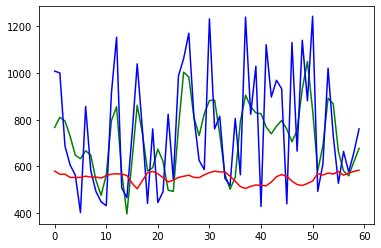

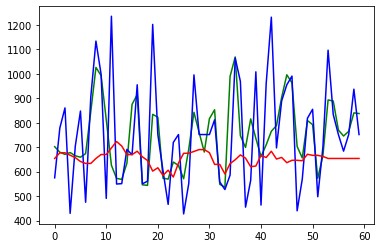

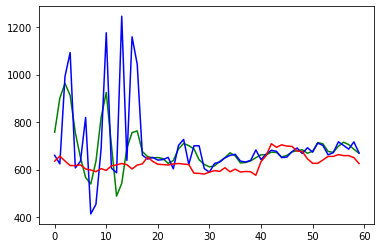

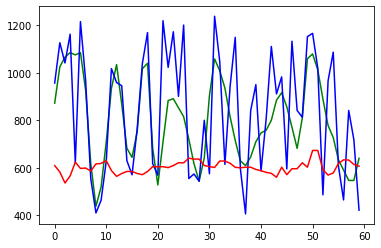

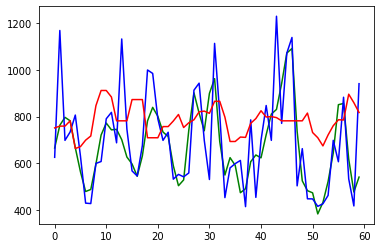

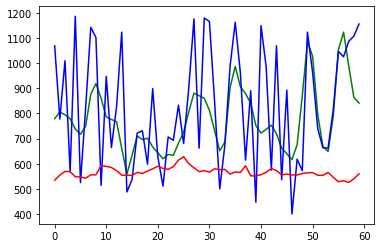

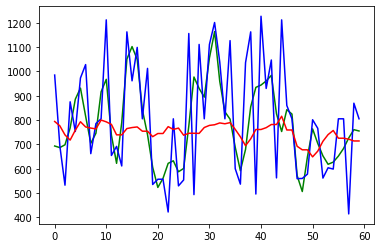

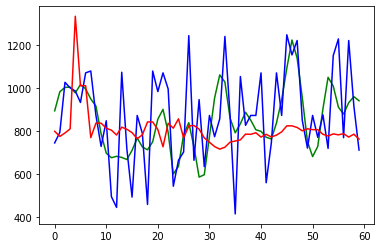

In [23]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[:20]):
#     if np.sum(a)>0:
    plt.figure()
    plt.plot(a,'g')
#     plt.plot(X_test[i,:,:4],'r')
    plt.plot(y_test[i],'b')
    plt.plot(ecg_test[i],'r')
    plt.show()

In [24]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [25]:
X = X[X[:,0]>-1]
X = X[X[:,2]>0]
X = X[X[:,3]>0]
X = X[X[:,1]>0]

(array([438437., 163388.,  93857.,  75996.,  67091.,  60504.,  55083.,
         54216.,  57158., 125991.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

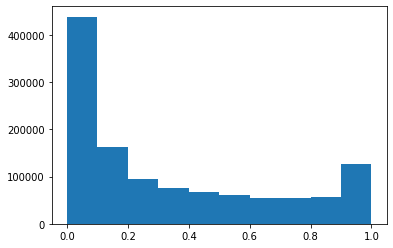

In [26]:
plt.hist(X[:,0])

(264835, 4) 0.0
(173602, 4) 0.05
(98798, 4) 0.1
(64590, 4) 0.15000000000000002
(50627, 4) 0.2
(42667, 4) 0.25
(39278, 4) 0.30000000000000004
(36718, 4) 0.35000000000000003
(34528, 4) 0.4
(32563, 4) 0.45
(31123, 4) 0.5
(29381, 4) 0.55
(27820, 4) 0.6000000000000001
(27648, 4) 0.65
(27029, 4) 0.7000000000000001
(27583, 4) 0.75
(28646, 4) 0.8
(29266, 4) 0.8500000000000001
(35209, 4) 0.9
(65564, 4) 0.9500000000000001
20 20


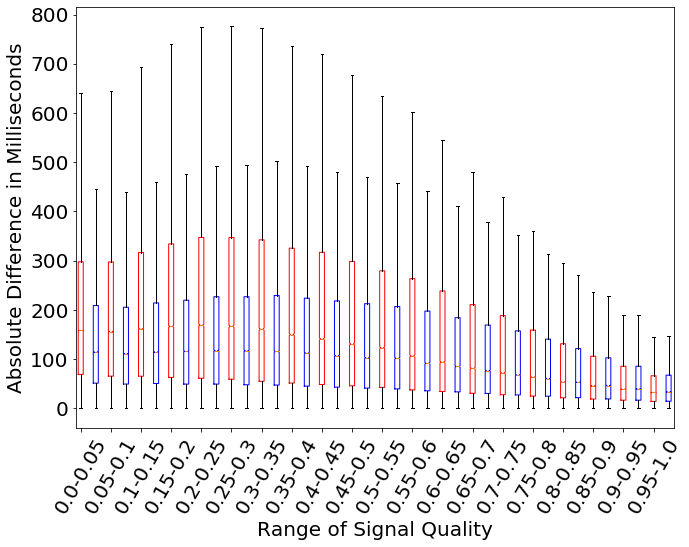

In [27]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [28]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'range_nni'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<10 or len(y_test_min)<10:
        continue
    x.append(np.array(list(get_time_domain_features(y_pred_min).values())))
    y.append(np.array(list(get_time_domain_features(ecg_min).values())))
    z.append(np.array(list(get_time_domain_features(y_test_min).values())))
    q.append(np.mean(qual_min))

In [29]:
preds,ecgs,fpreds,q = np.array(x),np.array(y),np.array(z),np.array(q)

In [30]:
preds.shape,ecgs.shape,fpreds.shape,q.shape

((19905, 16), (19905, 16), (19905, 16), (19905,))

In [31]:
preds[:,-5]

array([0.21656825, 0.22116156, 0.19587961, ..., 0.1416091 , 0.17237054,
       0.15519065])

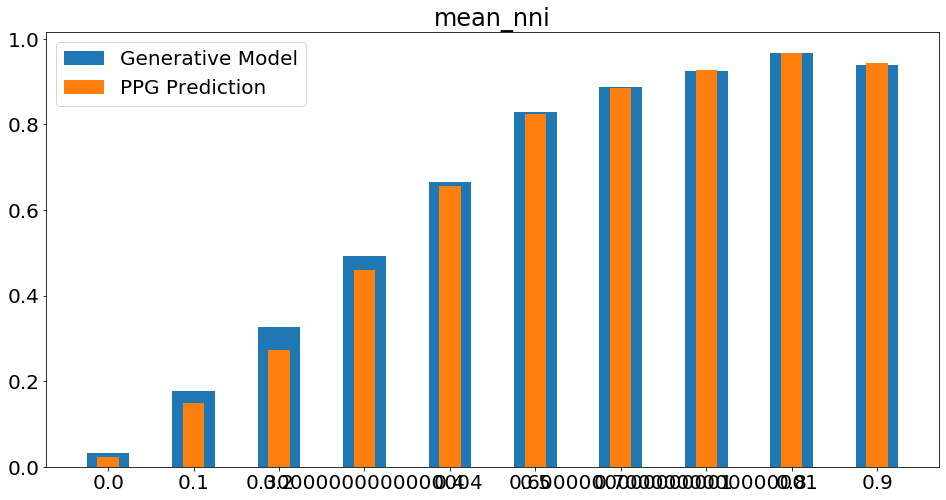

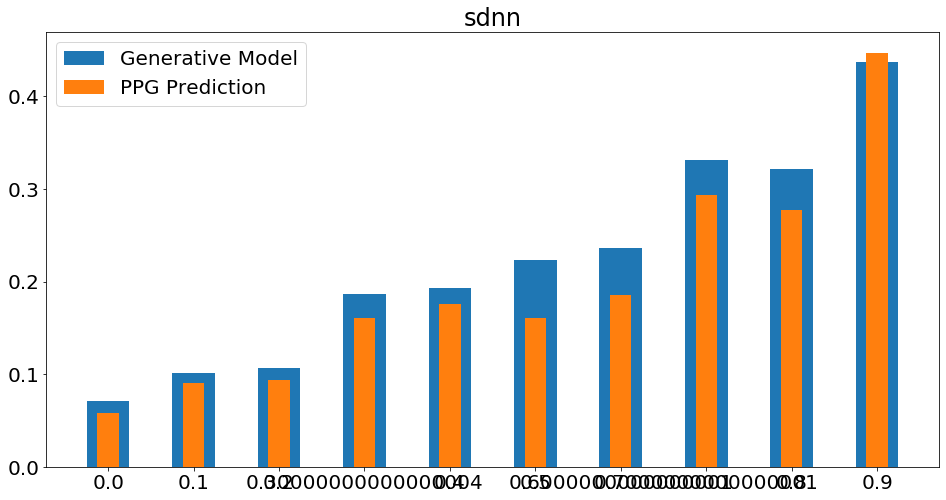

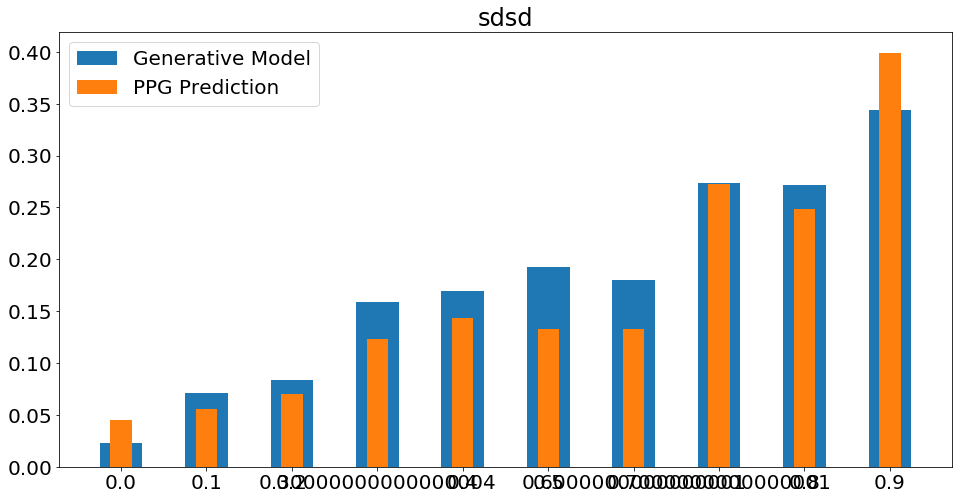

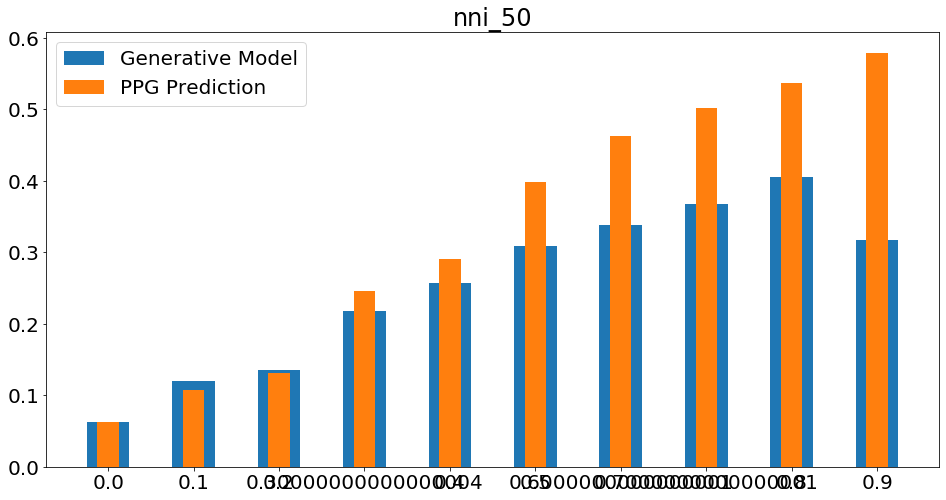

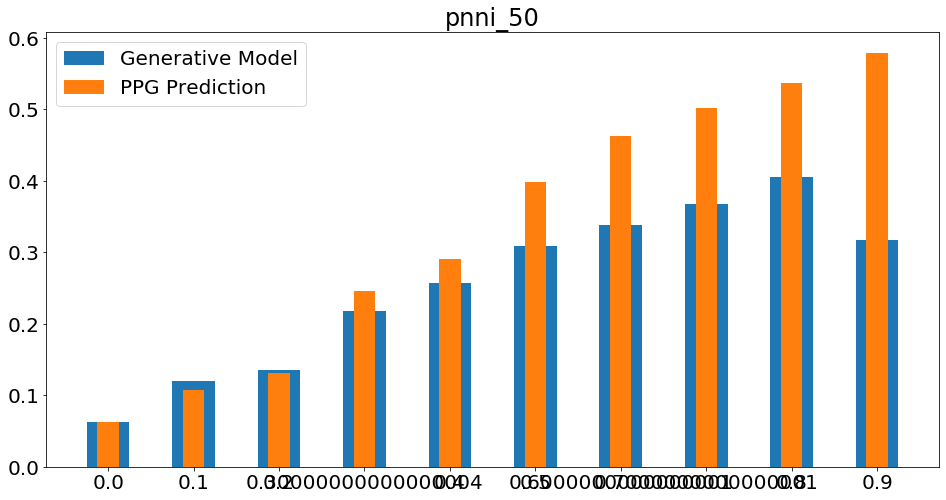

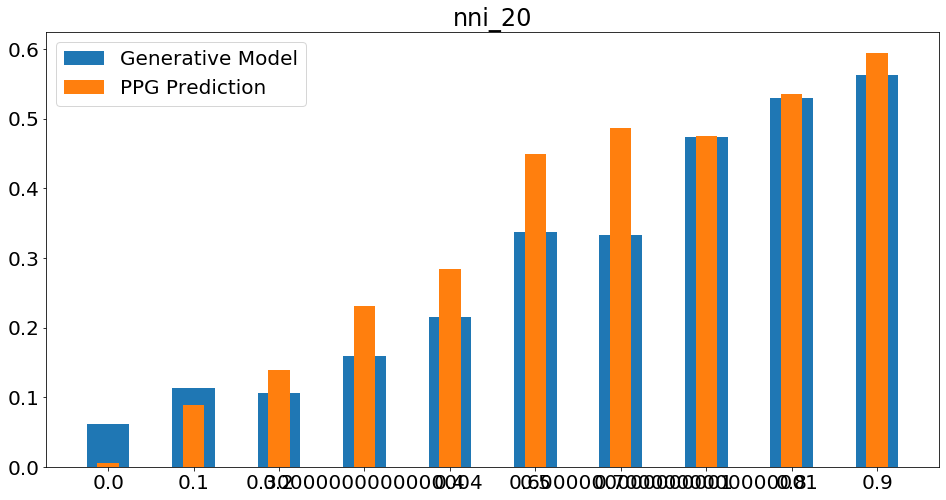

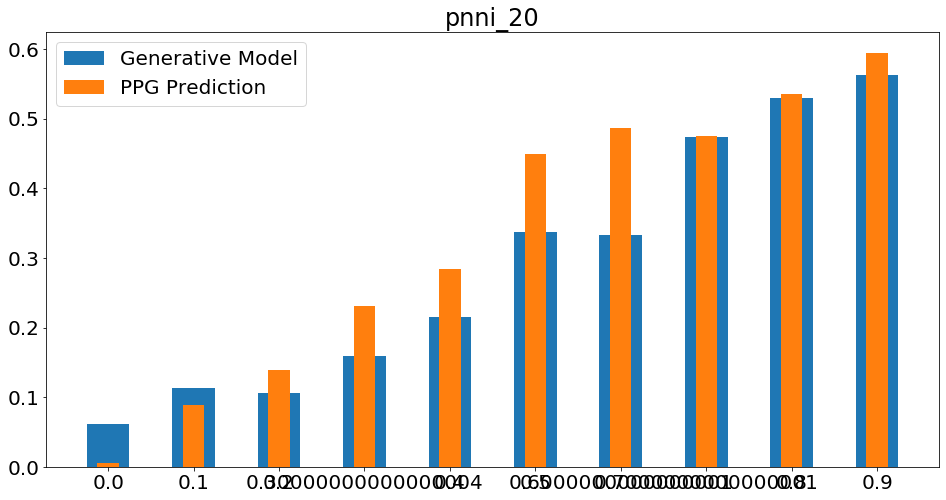

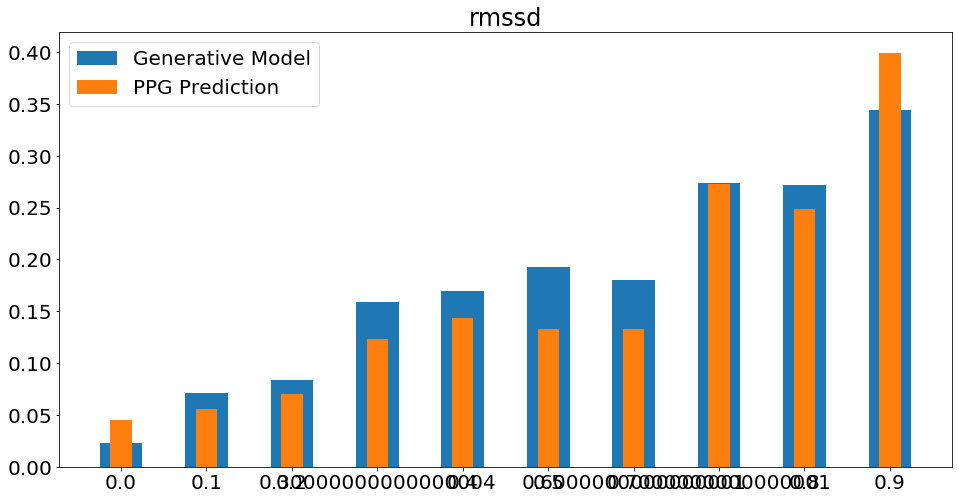

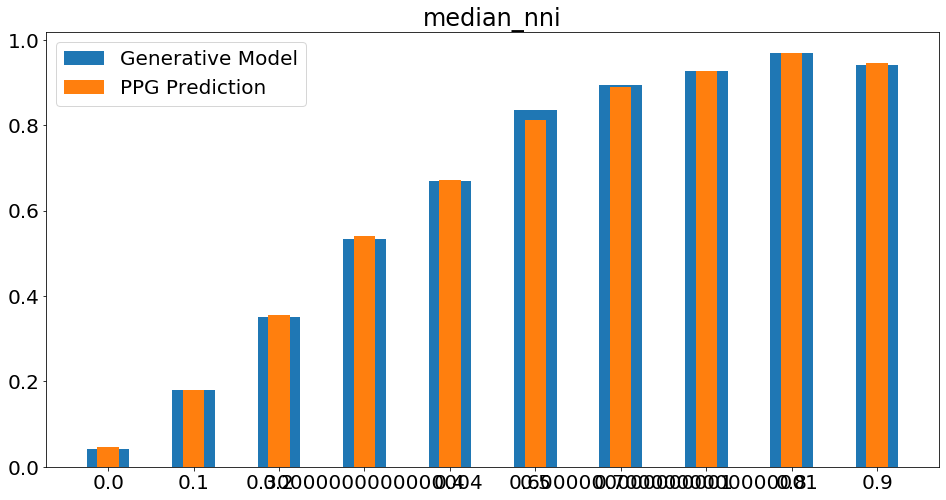

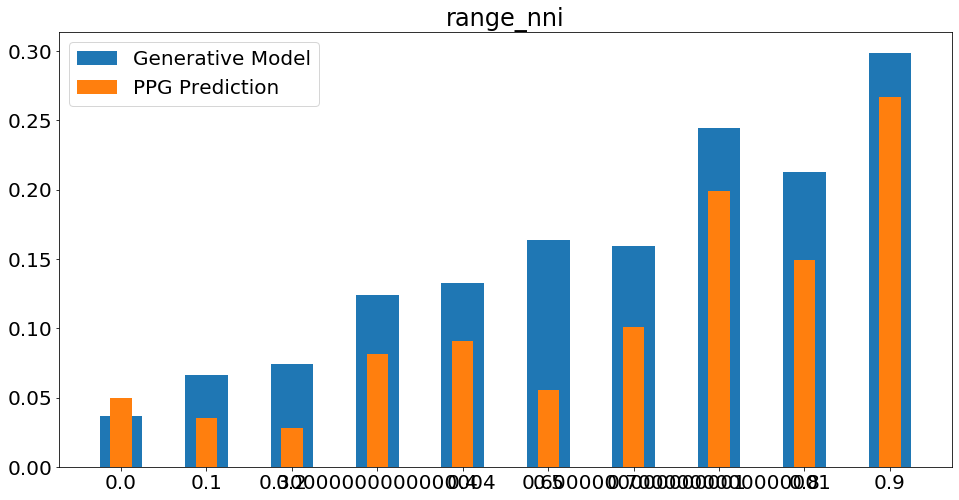

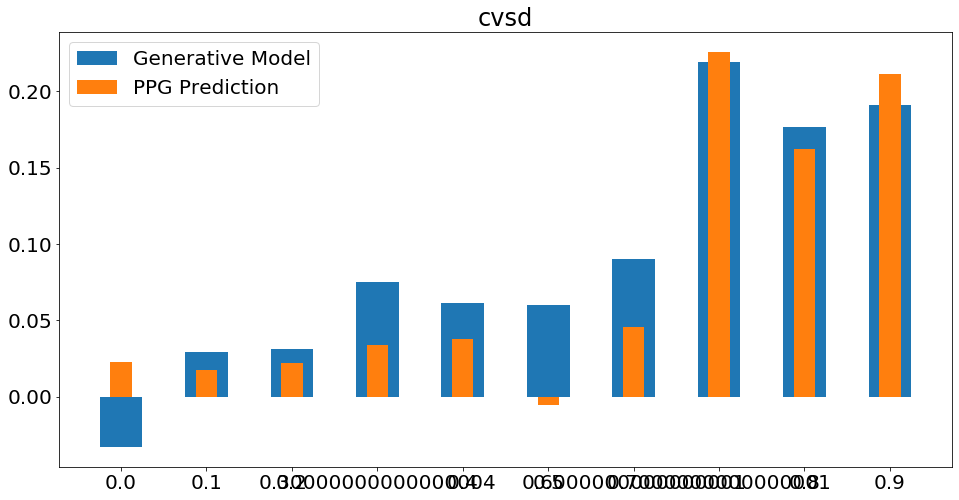

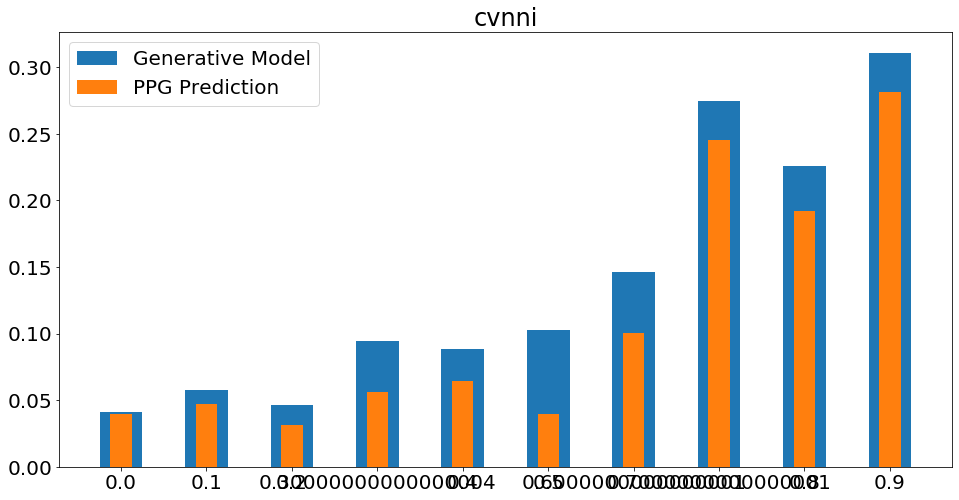

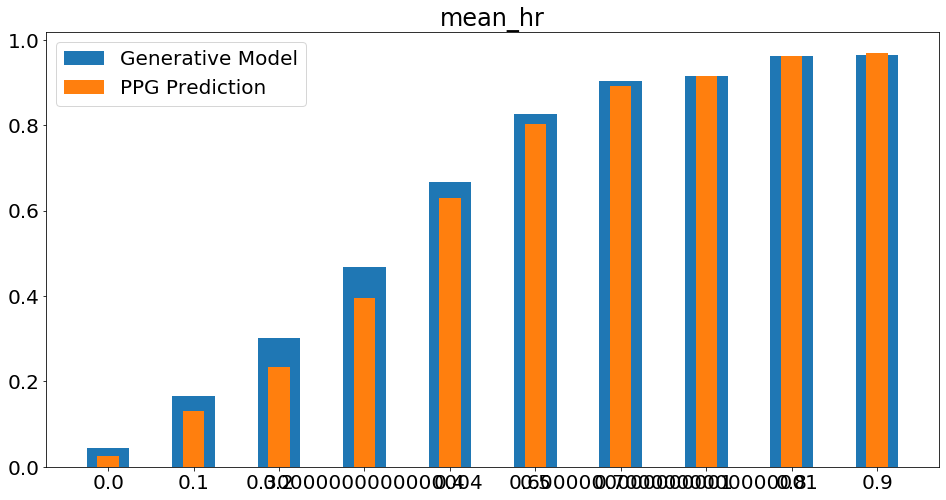

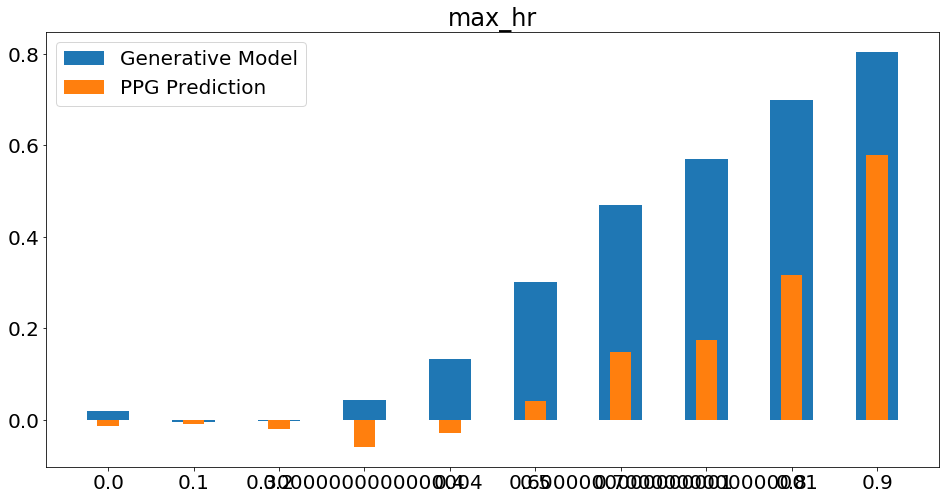

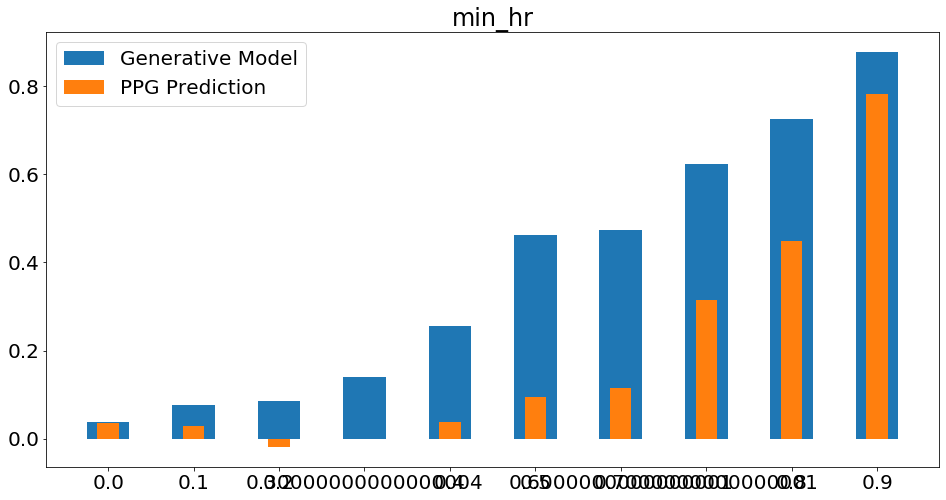

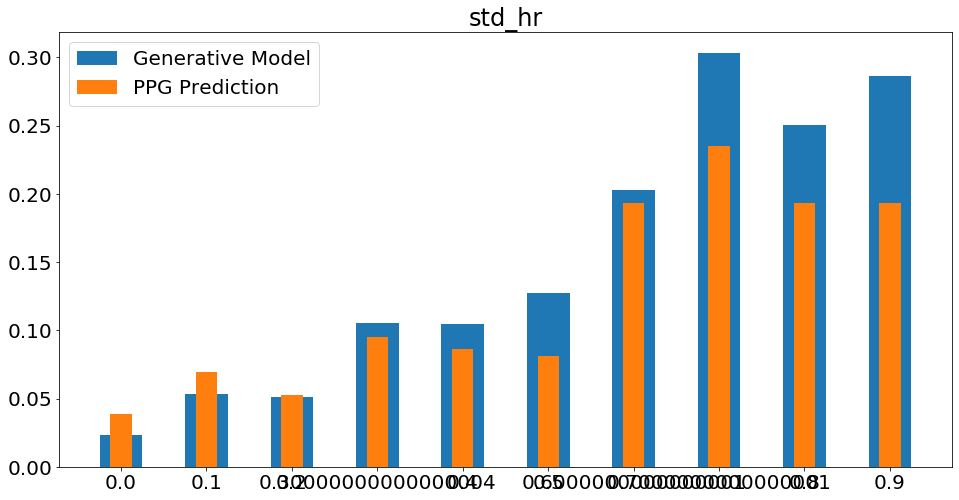

In [32]:
from scipy.stats import pearsonr
feature_col = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd',
 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr']

def get_pearson(x,y):
    index = ~np.isnan(x)
    x,y = x[index],y[index]
    index = ~np.isnan(y)
    x,y = x[index],y[index]
    return pearsonr(x,y)[0]

for j in range(len(feature_col)):
    x = []
    y = []
    y1 = []
    for i in np.linspace(0,.9,10):
        index = np.where((q>=i)&(q<=i+.10))[0]
#         print(len(index))
        if len(index)<10:
            continue
        x.append(str(i))
#         print(pearsonr(ecgs[index,j],preds[index,j])[0])
        try:
            y.append(get_pearson(ecgs[index,j],preds[index,j]))
            y1.append(get_pearson(ecgs[index,j],fpreds[index,j]))
        except:
            continue
    try:
        plt.figure(figsize=(16,8))
        plt.bar(x,y,.5,label='Generative Model')
        plt.bar(x,y1,.25,label='PPG Prediction')
        plt.title(feature_col[j])
        plt.legend()
        plt.show()
    except Exception as e:
        continue
        

In [ ]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'rmssd'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(get_time_domain_features(y_pred_min)[s])
    y.append(get_time_domain_features(ecg_min)[s])
    z.append(get_time_domain_features(y_test_min)[s])
    q.append(np.median(qual_min))
    if np.isinf(x[-1]) or np.isinf(y[-1]) or np.isinf(z[-1]) or np.isinf(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
    elif np.isnan(x[-1]) or np.isnan(y[-1]) or np.isnan(z[-1]) or np.isnan(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
#     print(np.std(ecg_min),np.std(y_test_min),np.std(y_pred_min),np.median(qual_min))
    
    

In [ ]:
from scipy.stats import pearsonr,spearmanr
q,x,y,z = np.array(q),np.array(x),np.array(y),np.array(z)
for i in np.linspace(0,.9,10):
    index = np.where((q>=i)&(q<=i+.1))[0]
    if len(index)<2:
        continue
    print(pearsonr(x[index],y[index]),pearsonr(y[index],z[index]),i,i+.1,len(index))

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
plt.hist(ecg_test.reshape(-1),50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))

In [ ]:
import keras

In [ ]:
keras.__version__

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
t = y_pred.reshape(-1)

In [ ]:
t[np.isfinite(t)].shape

In [ ]:
plt.hist(quals_test.reshape(-1))

In [ ]:
!pip install --user tensorflow-probability